#### 1. Импортируем библиотеки.

In [1]:
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

Для вещественных признаков попробуем рассмотреть матрицу корреляций (установим, что если коэффициент корреляции между двумя величинами < 0.0001, то мы считаем его нулевым):


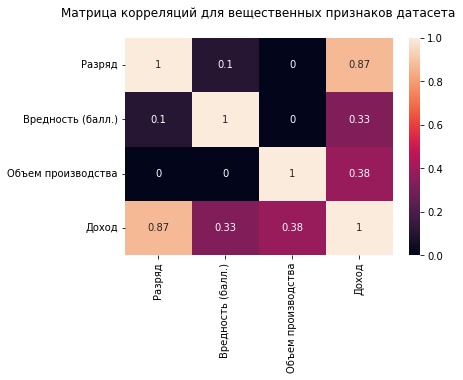

In [2]:
main_df = pd.read_excel('Задание 5.0 2 версия.xlsx')
corr = main_df.corr()
corr[corr < 1e-4] = 0

sns.heatmap(corr, annot = True, fmt='.2g')
plt.title('Матрица корреляций для вещественных признаков датасета\n')
plt.show()

По матрице корреляций можно сделать следующие выводы:

***Вывод 1***: Между собой признаки линейно не коррелируют.

***Вывод 2***: Все признаки по отдельности имеют некоторую линейную корреляцию с доходом, наиболее сильно коррелирует доход и разряд.

Таким образом, оклад, скорее всего, определяется в основном разрядом работника. Попробуем построить зависимость между разрядом и доходом.

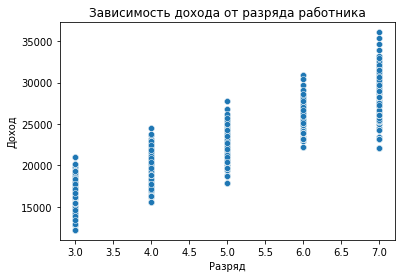

In [3]:
sns.scatterplot(data = main_df, x = "Разряд", y = "Доход")
plt.title('Зависимость дохода от разряда работника')
plt.show()

***Приближение 1***. Попробуем найти цену одного разряда.Для этого построим линейную аппроксимацию. Коэффициент наклона будет равен цене одного разряда.

In [4]:
from sklearn.linear_model import LinearRegression
lvl_df = main_df.drop(columns = ['FIO', 'Месяц', 'Профессия', 'Оборудование', 'Вредность (балл.)', 'Объем производства'])

regr_lvl = LinearRegression()
y_= lvl_df['Доход']
X_ = lvl_df.drop(columns = ['Доход'], inplace = False)

regr_lvl.fit(X_, y_)

y = regr_lvl.predict(X_)
print(f'Коэффициент наклона равен {round(*regr_lvl.coef_, 0)}')

Коэффициент наклона равен 2970.0


***Вывод 3.*** цена одного разряда составляет примерно 2970 руб.

***Приближение 2.*** Уровень вредости определяет профессия (кроме профессии "Уборщик"). Данное приближение позволяет сказать, что нам не столько важна профессия, сколько важен уровень ее вредности.

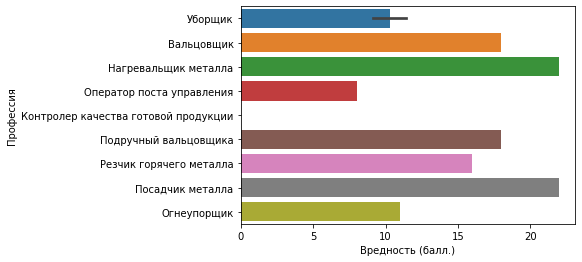

In [5]:
# Барплот профессия - вредность

sns.barplot(y = "Профессия", x = "Вредность (балл.)", data = main_df)

plt.show()

Действително, отличия работников по уровню вредности могут встречаться лишь в случае уборщиков (только для них приведен ненулевой доверительный интервал).

Далее попробуем построить мультилинейную регрессию для вредности и объёма производства.

***Приближение 3.*** Давайте предположим, что 580 - минимально необходимый объем работ, который должен совершить каждый работник

In [6]:
df = main_df.copy() # копируем исходный массив данных
df = df[df['Профессия'] == 'Уборщик']



df['Объем производства'] = df['Объем производства'] - 580

# удаляем ненужные столбцы, нам интересны только вредность и объём производства.
df = df.drop(columns = ['FIO', 'Месяц', 'Оборудование','Профессия', 'Разряд'])

df

# ubor_df
# # # 
y_ = df['Доход']
X_= df.drop(columns = ['Доход'])
X_
regr = LinearRegression()
regr.fit(X_, y_)

y = regr.predict(X_)

min(y_ - y), max(y_ - y)
pd.DataFrame(regr.feature_names_in_, regr.coef_)
# regr.intercept_

,0
175.848230,Вредность (балл.)
5.602234,Объем производства


Обратим внимание, что каждая профессия имеет определенный уровень вредности (кроме профессии "Уборщик"). Это можно обнаружить, построив график barplot (из библиотеки seaborn): только у одного бина приводится доверительный интервал, что говорит о различных уровнях вредности Уборщиков. Все остальные бины не имеют доверительного интервала, что говорит о том, что значения уровня вредности для любого представителя определенный профессии (кроме уборщика) равны.

Можно рассмотреть ЗП Уборщика, чтобы оценить уровень доплаты за вредность.

<AxesSubplot:xlabel='Объем производства', ylabel='Профессия'>

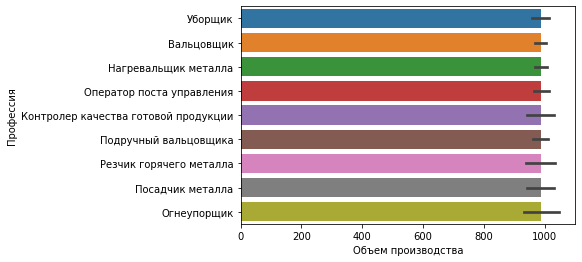

In [7]:
sns.barplot(y = "Профессия", x = "Объем производства", data = main_df, estimator = np.mean)

(8213.788625122404, array([175.84822985,   5.60223351]))

Для чего это может быть полезно? Можно попробовать обучить модель типа "Линейная регрессия" для конкретных профессий.

Обучим в первом приближении